## Hypothesis:
    It is possible to predict whether a talk is popular or not based on its transcript.

* What linguistic features might be influencing the classifier's decisions:

    1. **The average K-band of the transcript**- The more popular the talk, the lower the Kband mean. Why? Because we usually don't want the speaker to use a lot of terminologies that are only used in the field they explain or work.

    2. **The syntactic complexity of the transcript** - the more consicely the speakers deliver their talk, the more likely it will get more positive review.

* How to define _POPULAR_ talk?  
    I am here using `rating` as a tool to define the popular talk; if the ratio of positive review of a talk is higher than its negative review, I will consider it popular.

* What is _K-band_?
    This is one of the ways to measure the vocabulary level of a writing. Since common, everyday words are used more frequently than technical, sophisticated words, it measures the level of a word by its frequency. The k-band in this project is built on the unigram collected by Google, the 1/3 million most frequent words on the platform.

## Data Cleaning & Reorganizing

In [1]:
import pandas as pd
import numpy as np
import math
import nltk
import matplotlib.pylab as plt           
import seaborn as sns

In [2]:
# read files
ted = pd.read_csv("../data_full/ted_main.csv")
tran = pd.read_csv("../data_full/transcripts.csv")

In [3]:
# remove NAs
ted.dropna(inplace=True)
tran.dropna(inplace=True)

In [4]:
print(ted.info())
print('---'*15)
print(tran.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544 entries, 0 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2544 non-null   int64 
 1   description         2544 non-null   object
 2   duration            2544 non-null   int64 
 3   event               2544 non-null   object
 4   film_date           2544 non-null   int64 
 5   languages           2544 non-null   int64 
 6   main_speaker        2544 non-null   object
 7   name                2544 non-null   object
 8   num_speaker         2544 non-null   int64 
 9   published_date      2544 non-null   int64 
 10  ratings             2544 non-null   object
 11  related_talks       2544 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2544 non-null   object
 14  title               2544 non-null   object
 15  url                 2544 non-null   object
 16  views               2544

* There is already a difference in the number of rows in each data set. It indicates that I might lose 77 rows in `ted_main` set at most.

In [5]:
# sorting the main TED conference only
ted_main = ted[ted['event'].str.fullmatch(r'TED\d\d\d\d')]


In [6]:
# combine two files
ted_clean = pd.merge(ted_main, tran, on = 'url')
ted_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 971
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            972 non-null    int64 
 1   description         972 non-null    object
 2   duration            972 non-null    int64 
 3   event               972 non-null    object
 4   film_date           972 non-null    int64 
 5   languages           972 non-null    int64 
 6   main_speaker        972 non-null    object
 7   name                972 non-null    object
 8   num_speaker         972 non-null    int64 
 9   published_date      972 non-null    int64 
 10  ratings             972 non-null    object
 11  related_talks       972 non-null    object
 12  speaker_occupation  972 non-null    object
 13  tags                972 non-null    object
 14  title               972 non-null    object
 15  url                 972 non-null    object
 16  views               972 no

* While merging two dataset, 6 values are lost.

In [7]:
url = pd.concat([ted.url, tran.url], axis = 1)
url.tail(10)

,url,url
2546,https://www.ted.com/talks/armando_azua_bustos_...,NaN
2547,https://www.ted.com/talks/radhika_nagpal_what_...,NaN
2548,https://www.ted.com/talks/theo_e_j_wilson_a_bl...,NaN
2549,https://www.ted.com/talks/karoliina_korppoo_ho...,NaN
1113,NaN,https://www.ted.com/talks/billy_collins_everyd...
1192,NaN,https://www.ted.com/talks/peter_norvig_the_100...
1220,NaN,https://www.ted.com/talks/james_stavridis_how_...
1656,NaN,https://www.ted.com/talks/mellody_hobson_color...
1911,NaN,https://www.ted.com/talks/suki_kim_this_is_wha...
1949,NaN,https://www.ted.com/talks/christopher_soghoian...


* The reason for the lost 6 rows is because there are 6 NaNs in `ted` data set.
* But, shouldn't `dropna()` method have worked on NaN values too? Hmm.

In [8]:
# select the columns I need
ted_clean = ted_clean[['title', 'event', 'comments', 'ratings', 'transcript']]
ted_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 971
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       972 non-null    object
 1   event       972 non-null    object
 2   comments    972 non-null    int64 
 3   ratings     972 non-null    object
 4   transcript  972 non-null    object
dtypes: int64(1), object(4)
memory usage: 45.6+ KB


In [9]:
# tokenize the transcript
ted_clean['token'] = ted_clean.transcript.map(nltk.word_tokenize)

In [10]:
# code from stackoverflow: https://stackoverflow.com/questions/51688521/lowercase-sentences-in-lists-in-pandas-dataframe
ted_clean['tok_low'] = ted_clean.token.map(lambda x: list(map(str.lower, x)))

In [11]:
ted_clean.sample(5)

,title,event,comments,ratings,transcript,token,tok_low
811,The surprising way groups like ISIS stay in power,TED2015,265,"[{'id': 8, 'name': 'Informative', 'count': 108...","For the past decade, I've been studying non-st...","[For, the, past, decade, ,, I, 've, been, stud...","[for, the, past, decade, ,, i, 've, been, stud..."
434,The case for anonymity online,TED2010,477,"[{'id': 22, 'name': 'Fascinating', 'count': 36...",Tom Green: That's a 4chan thing. These kids on...,"[Tom, Green, :, That, 's, a, 4chan, thing, ., ...","[tom, green, :, that, 's, a, 4chan, thing, ., ..."
583,New ways to see music (with color! and fire!),TED2012,48,"[{'id': 2, 'name': 'Confusing', 'count': 12}, ...","My passions are music, technology and making t...","[My, passions, are, music, ,, technology, and,...","[my, passions, are, music, ,, technology, and,..."
969,The most Martian place on Earth,TED2017,6,"[{'id': 22, 'name': 'Fascinating', 'count': 32...",This is a picture of a sunset on Mars taken by...,"[This, is, a, picture, of, a, sunset, on, Mars...","[this, is, a, picture, of, a, sunset, on, mars..."
409,Every pollen grain has a story,TED2010,59,"[{'id': 22, 'name': 'Fascinating', 'count': 25...",Thank you. I have two missions here today. The...,"[Thank, you, ., I, have, two, missions, here, ...","[thank, you, ., i, have, two, missions, here, ..."


In [12]:
# read files to make kband for the transcript analysis
# Codes created by Dr. Han
flines = open("C:/Users/82102/Desktop/program/2022_fall/LING 2231/count_1w.txt").readlines()
google_1gram_tup = [tuple(line.split()) for line in flines]
google_1gram_rank = {word:index+1 for (index,(word, count)) in enumerate(google_1gram_tup)}

* Future me: need to specify `count_1w.txt` origin and the definition of kband

In [13]:
# Build kband function, using the code Dr. Han created
def get_avg_google_kband(toks):
    kbands = []
    for t in toks:
        if t.lower() in google_1gram_rank: 
           grank = google_1gram_rank[t.lower()]
           if grank <= 100000:  
               kband = math.floor(grank/1000)+1
               kbands.append(kband)
    return np.mean(kbands)

In [14]:
get_avg_google_kband(ted_clean.token[0])

2.712989957887917

* Nice it works.

In [15]:
ted_clean['kband_ave'] = ted_clean.token.map(get_avg_google_kband)

In [16]:
ted_clean.describe()

,comments,kband_ave
count,972.000000,972.000000
mean,212.526749,3.127864
std,371.132528,0.927790
min,6.000000,1.858444
25%,64.000000,2.637509
50%,121.500000,2.959547
75%,233.000000,3.404999
max,6404.000000,13.780000


* There are some unexpectedly high mean Kbands.. Let's see what they are.

In [17]:
# check the max kband_ave because it does not make sense..
ted_clean[ted_clean.kband_ave == 13.78]

,title,event,comments,ratings,transcript,token,tok_low,kband_ave
76,"""La Vie en Rose""",TED2004,39,"[{'id': 7, 'name': 'Funny', 'count': 58}, {'id...",Thomas Dolby: For pure pleasure please welcome...,"[Thomas, Dolby, :, For, pure, pleasure, please...","[thomas, dolby, :, for, pure, pleasure, please...",13.78


In [18]:
# calculate token count and its mean
ted_clean['tok_count'] = ted_clean.tok_low.map(len)
np.mean(ted_clean.tok_count)

2379.0812757201647

In [19]:
# checking the token # to check if the token count is causing this problem
ted_clean[ted_clean.kband_ave == 13.78]['tok_count']

76    151
Name: tok_count, dtype: int64

* Oookayy, maybe I should sort the data by token count for a better result.

In [20]:
ted_clean[ted_clean.kband_ave > 5]

,title,event,comments,ratings,transcript,token,tok_low,kband_ave,tok_count
62,The story of life in photographs,TED2005,143,"[{'id': 1, 'name': 'Beautiful', 'count': 1262}...",Nature's my muse and it's been my passion. As ...,"[Nature, 's, my, muse, and, it, 's, been, my, ...","[nature, 's, my, muse, and, it, 's, been, my, ...",5.420904,1314
64,"Global warming's theme song, ""Manhattan in Jan...",TED2006,39,"[{'id': 9, 'name': 'Ingenious', 'count': 45}, ...",Okay.♫ Strolling along in Central Park ♫♫ Ever...,"[Okay.♫, Strolling, along, in, Central, Park, ...","[okay.♫, strolling, along, in, central, park, ...",5.298387,185
76,"""La Vie en Rose""",TED2004,39,"[{'id': 7, 'name': 'Funny', 'count': 58}, {'id...",Thomas Dolby: For pure pleasure please welcome...,"[Thomas, Dolby, :, For, pure, pleasure, please...","[thomas, dolby, :, for, pure, pleasure, please...",13.780000,151
113,My magic moves,TED2007,101,"[{'id': 7, 'name': 'Funny', 'count': 307}, {'i...",(Applause)(Music)(Applause),"[(, Applause, ), (, Music, ), (, Applause, )]","[(, applause, ), (, music, ), (, applause, )]",13.666667,9
215,"""The Dog Song""",TED2008,45,"[{'id': 7, 'name': 'Funny', 'count': 255}, {'i...",I’d like to dedicate this next song to Carmelo...,"[I, ’, d, like, to, dedicate, this, next, song...","[i, ’, d, like, to, dedicate, this, next, song...",5.427481,583
293,Seas of plastic,TED2009,165,"[{'id': 25, 'name': 'OK', 'count': 54}, {'id':...","Let's talk trash.You know, we had to be taught...","[Let, 's, talk, trash.You, know, ,, we, had, t...","[let, 's, talk, trash.you, know, ,, we, had, t...",5.026471,1198
310,Poetry of youth and age,TED2001,39,"[{'id': 11, 'name': 'Longwinded', 'count': 27}...",I thought I would read poems I have that relat...,"[I, thought, I, would, read, poems, I, have, t...","[i, thought, i, would, read, poems, i, have, t...",5.690902,3294
382,An all-star set,TED2009,74,"[{'id': 3, 'name': 'Courageous', 'count': 14},...",(Music)(Applause)(Music)(Music) (Applause)(Mus...,"[(, Music, ), (, Applause, ), (, Music, ), (, ...","[(, music, ), (, applause, ), (, music, ), (, ...",8.880000,53
496,"On violin and cello, ""Passacaglia""",TED2011,72,"[{'id': 1, 'name': 'Beautiful', 'count': 545},...",(Music)(Applause)(Music)(Applause),"[(, Music, ), (, Applause, ), (, Music, ), (, ...","[(, music, ), (, applause, ), (, music, ), (, ...",10.500000,12
575,Dancing with light,TED2012,109,"[{'id': 1, 'name': 'Beautiful', 'count': 411},...",(Music)(Applause)(Music)(Applause)(Music)(Appl...,"[(, Music, ), (, Applause, ), (, Music, ), (, ...","[(, music, ), (, applause, ), (, music, ), (, ...",10.500000,24


* I have checked how many rows have the average k-band higher than 5, and there are only 15, and all of them are not a *real* talk; dance, song, visualization of something, etc. So, I will remove these values from the data set.

In [21]:
ted_clean = ted_clean[ted_clean.kband_ave < 5]

In [22]:
ted_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957 entries, 0 to 971
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       957 non-null    object 
 1   event       957 non-null    object 
 2   comments    957 non-null    int64  
 3   ratings     957 non-null    object 
 4   transcript  957 non-null    object 
 5   token       957 non-null    object 
 6   tok_low     957 non-null    object 
 7   kband_ave   957 non-null    float64
 8   tok_count   957 non-null    int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 74.8+ KB


#### Trying to find a way to incorporate `comments` information.. 

In [23]:
# reset index for future data wrangling
ted_clean.reset_index(drop=True, inplace=True)

In [24]:
# take log on comments column
ted_clean['log_com'] = ted_clean['comments'].map(math.log)

c:\Users\82102\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_com', ylabel='kband_ave'>

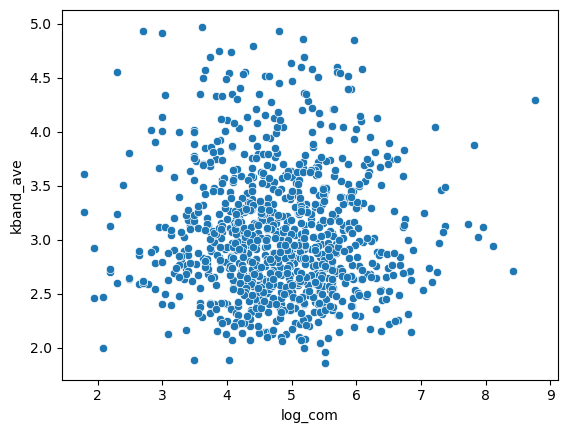

In [25]:
# make a scatter plot to see if there is any linear correlation between comments and kband
sns.scatterplot(ted_clean['log_com'], ted_clean['kband_ave'])

* No correlation between `comments` and the average k-band..

In [26]:
import re

In [27]:
# remove unnecessary strings
ted_clean['ratings_tok'] = ted_clean.ratings.map(lambda x: re.sub(r'\[|\]|\{|\}|:|,|\'', '', x))

In [28]:
ted_clean.head()

,title,event,comments,ratings,transcript,token,tok_low,kband_ave,tok_count,log_com,ratings_tok
0,Do schools kill creativity?,TED2006,4553,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Good morning. How are you?(Laughter)It's been ...,"[Good, morning, ., How, are, you, ?, (, Laught...","[good, morning, ., how, are, you, ?, (, laught...",2.712990,3938,8.423542,id 7 name Funny count 19645 id 1 name Beautifu...
1,Averting the climate crisis,TED2006,265,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","Thank you so much, Chris. And it's truly a gre...","[Thank, you, so, much, ,, Chris, ., And, it, '...","[thank, you, so, much, ,, chris, ., and, it, '...",2.777508,2556,5.579730,id 7 name Funny count 544 id 3 name Courageous...
2,Simplicity sells,TED2006,124,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","(Music: ""The Sound of Silence,"" Simon & Garfun...","[(, Music, :, ``, The, Sound, of, Silence, ,, ...","[(, music, :, ``, the, sound, of, silence, ,, ...",2.750460,4262,4.820282,id 7 name Funny count 964 id 3 name Courageous...
3,Greening the ghetto,TED2006,200,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",If you're here today — and I'm very happy that...,"[If, you, 're, here, today, —, and, I, 'm, ver...","[if, you, 're, here, today, —, and, i, 'm, ver...",3.192360,3533,5.298317,id 3 name Courageous count 760 id 1 name Beaut...
4,The best stats you've ever seen,TED2006,593,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","About 10 years ago, I took on the task to teac...","[About, 10, years, ago, ,, I, took, on, the, t...","[about, 10, years, ago, ,, i, took, on, the, t...",2.155352,3715,6.385194,id 9 name Ingenious count 3202 id 7 name Funny...


In [29]:
# collect rating names only
rating_name = []
for i in ted_clean.ratings_tok.map(nltk.word_tokenize):
    for j in i:
        if j[0].isupper():
            rating_name.append(j) 
print(list(set(rating_name)))

['OK', 'Inspiring', 'Informative', 'Ingenious', 'Confusing', 'Fascinating', 'Unconvincing', 'Persuasive', 'Funny', 'Obnoxious', 'Beautiful', 'Longwinded', 'Jaw-dropping', 'Courageous']


In [30]:
len(set(rating_name))

14

* So, there are 14 different rating kinds.
* 4 out of 14 ratings are negative ratings

In [31]:
# make lists for positive/negative ratings, removing 'OK' from positive list
negative = ['Unconvincing', 'Obnoxious', 'Confusing', 'Longwinded']
positive = [w for w in set(rating_name) if w not in negative]
positive.remove('OK')

In [32]:
rating_split = ted_clean['ratings_tok'].str.split(' ')

In [33]:
# !!!!!!!!!!!!!!! found a way to extract the only information I need!
rating_split.str.get(0)

0      id
1      id
2      id
3      id
4      id
       ..
952    id
953    id
954    id
955    id
956    id
Name: ratings_tok, Length: 957, dtype: object

In [34]:
# extract rating name only in each value
x = []
for i in range(3, 85, 6):
    x.append(rating_split.str.get(i))
print(pd.DataFrame(x).head())

                    0             1             2           3           4    \
ratings_tok       Funny         Funny         Funny  Courageous   Ingenious   
ratings_tok   Beautiful    Courageous    Courageous   Beautiful       Funny   
ratings_tok   Ingenious     Confusing     Ingenious   Confusing   Beautiful   
ratings_tok  Courageous     Beautiful     Beautiful       Funny  Courageous   
ratings_tok  Longwinded  Unconvincing  Unconvincing   Ingenious  Longwinded   

                      5             6             7             8    \
ratings_tok         Funny    Courageous     Ingenious    Courageous   
ratings_tok    Courageous         Funny     Beautiful     Confusing   
ratings_tok  Unconvincing     Ingenious    Longwinded  Unconvincing   
ratings_tok     Confusing  Unconvincing    Courageous         Funny   
ratings_tok     Beautiful     Beautiful  Unconvincing    Longwinded   

                      9    ...          947          948           949  \
ratings_tok  Unconvincin

In [35]:
# extract rating count only
y = []
for i in range(5, 85, 6):
    y.append(rating_split.str.get(i))
print(pd.DataFrame(y).head())

               0    1    2    3     4     5     6    7    8    9    ...  947  \
ratings_tok  19645  544  964  760  3202  1102   477  195  562  838  ...    2   
ratings_tok   4573  139   45  291  1390   721  2484   98   70  767  ...   32   
ratings_tok   6073   62  183   32   942   377   320   26  283  476  ...   67   
ratings_tok   3253   58   60   59   318   301   225   34   60  116  ...   79   
ratings_tok    387  258  104  105   110   706   277   26  177  306  ...  148   

             948 949  950 951 952 953 954 955 956  
ratings_tok   26  29  484  73  13  24  32  14  21  
ratings_tok  214   7  109  78  68  33  38  32  25  
ratings_tok  218  20  294  19  41  27  20  19  26  
ratings_tok  170  13  677  28  31   1   7  30  11  
ratings_tok   71  42   61  36   6  24   8   2   9  

[5 rows x 957 columns]


In [36]:
# make them into a dataframe, removing index
X = pd.DataFrame(x)
Y = pd.DataFrame(y)
X.reset_index(drop = True, inplace = True)
Y.reset_index(drop = True, inplace = True)

In [37]:
# make a new df containing tuples of rating name and rating count
new_df = pd.DataFrame(index=range(X.shape[1]), columns=['rating'])

for i in range(X.shape[1]):
    new_df.rating[i] = tuple(zip(X[i], Y[i]))
    

In [38]:
# insert it to the main dataset
ted_clean['ratings_tuple'] = new_df.rating

In [39]:
ted_clean.head()

,title,event,comments,ratings,transcript,token,tok_low,kband_ave,tok_count,log_com,ratings_tok,ratings_tuple
0,Do schools kill creativity?,TED2006,4553,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...",Good morning. How are you?(Laughter)It's been ...,"[Good, morning, ., How, are, you, ?, (, Laught...","[good, morning, ., how, are, you, ?, (, laught...",2.712990,3938,8.423542,id 7 name Funny count 19645 id 1 name Beautifu...,"((Funny, 19645), (Beautiful, 4573), (Ingenious..."
1,Averting the climate crisis,TED2006,265,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","Thank you so much, Chris. And it's truly a gre...","[Thank, you, so, much, ,, Chris, ., And, it, '...","[thank, you, so, much, ,, chris, ., and, it, '...",2.777508,2556,5.579730,id 7 name Funny count 544 id 3 name Courageous...,"((Funny, 544), (Courageous, 139), (Confusing, ..."
2,Simplicity sells,TED2006,124,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","(Music: ""The Sound of Silence,"" Simon & Garfun...","[(, Music, :, ``, The, Sound, of, Silence, ,, ...","[(, music, :, ``, the, sound, of, silence, ,, ...",2.750460,4262,4.820282,id 7 name Funny count 964 id 3 name Courageous...,"((Funny, 964), (Courageous, 45), (Ingenious, 1..."
3,Greening the ghetto,TED2006,200,"[{'id': 3, 'name': 'Courageous', 'count': 760}...",If you're here today — and I'm very happy that...,"[If, you, 're, here, today, —, and, I, 'm, ver...","[if, you, 're, here, today, —, and, i, 'm, ver...",3.192360,3533,5.298317,id 3 name Courageous count 760 id 1 name Beaut...,"((Courageous, 760), (Beautiful, 291), (Confusi..."
4,The best stats you've ever seen,TED2006,593,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","About 10 years ago, I took on the task to teac...","[About, 10, years, ago, ,, I, took, on, the, t...","[about, 10, years, ago, ,, i, took, on, the, t...",2.155352,3715,6.385194,id 9 name Ingenious count 3202 id 7 name Funny...,"((Ingenious, 3202), (Funny, 1390), (Beautiful,..."


In [40]:
# test a code to calculate each percentage of positive review and negative review

total = 0
pos_total = 0
neg_total = 0

for name, count in ted_clean.ratings_tuple[0]:
    if name != "OK":
        total += int(count)

for name, count in ted_clean.ratings_tuple[0]:
    if name in positive:
        if name != "OK":
            name = "POS"
            count = (int(count)*100)/total
        else:
            name = "OK"
    else:
        name = "NEG"
        count = (int(count)*100)/total

    print(name, count)

    if name == "POS":
        pos_total += count
    elif name == "NEG":
        neg_total += count


print((pos_total, neg_total))

POS 21.197505287237256
POS 4.934395096896716
POS 6.552937114247486
POS 3.5100781216280375
NEG 0.41758384047649877
NEG 0.2611247787992576
POS 7.9265397729725064
POS 11.417195390392335
NEG 0.32370840347015406
POS 11.549915835815098
POS 4.789805343346713
NEG 1.2667788855798696
NEG 0.22551685441754069
POS 26.893694160300402
(98.77206612283655, 2.4947127627433203)


In [41]:
# build a function based on the code above converting it to list comprehension

def cal_perc(data):

    total = sum([int(count) for (name, count) in data])

    pos_total = sum([int(count) for (name, count) in data if name in positive])
    neg_total = sum([int(count) for (name, count) in data if name in negative])

    return (round(pos_total*100/total, 4), round(neg_total*100/total, 4))

In [42]:
ted_clean['pos_neg'] = ted_clean.ratings_tuple.map(lambda x: cal_perc(x))

In [43]:
ted_clean[['pos_neg']].head(10)

,pos_neg
0,"(97.5365, 1.2126)"
1,"(73.876, 19.2098)"
2,"(82.4008, 12.4292)"
3,"(93.5354, 4.1845)"
4,"(97.822, 1.21)"
5,"(88.6754, 8.4527)"
6,"(81.8606, 13.0043)"
7,"(85.8398, 8.0078)"
8,"(80.5626, 15.5347)"
9,"(77.5309, 19.5268)"


* OMG it worked!!!!!!

In [44]:
# calculate the mean percentage of positive review and negative review

pos_total = 0
neg_total = 0

for p, n in ted_clean['pos_neg']:
    pos_total += p
    neg_total += n

mean_pos = pos_total/len(ted_clean['pos_neg'])
mean_neg = neg_total/len(ted_clean['pos_neg'])

print(mean_pos, mean_neg)

87.00269299895524 8.12041368861024


* Since the rating of ted talk is the result of multiple choices out of 14 options, it is not possible to classify the talk based on its absolute value of review.
* As shown above, the mean percentage of positive review is a whopping 91%.
* Therefore, I will classify the reviews based on the percentage of its **negative review only**; if the percentage of negative value of a talk is higher than the mean of negative review, which is 8.12, I will label it as negative, or not popular.

In [45]:
# re-sort the columns I need
ted_clean = ted_clean[['title', 'comments', 'transcript', 'tok_low', 'kband_ave', 'ratings_tuple', 'pos_neg']]
ted_clean.head()

,title,comments,transcript,tok_low,kband_ave,ratings_tuple,pos_neg
0,Do schools kill creativity?,4553,Good morning. How are you?(Laughter)It's been ...,"[good, morning, ., how, are, you, ?, (, laught...",2.712990,"((Funny, 19645), (Beautiful, 4573), (Ingenious...","(97.5365, 1.2126)"
1,Averting the climate crisis,265,"Thank you so much, Chris. And it's truly a gre...","[thank, you, so, much, ,, chris, ., and, it, '...",2.777508,"((Funny, 544), (Courageous, 139), (Confusing, ...","(73.876, 19.2098)"
2,Simplicity sells,124,"(Music: ""The Sound of Silence,"" Simon & Garfun...","[(, music, :, ``, the, sound, of, silence, ,, ...",2.750460,"((Funny, 964), (Courageous, 45), (Ingenious, 1...","(82.4008, 12.4292)"
3,Greening the ghetto,200,If you're here today — and I'm very happy that...,"[if, you, 're, here, today, —, and, i, 'm, ver...",3.192360,"((Courageous, 760), (Beautiful, 291), (Confusi...","(93.5354, 4.1845)"
4,The best stats you've ever seen,593,"About 10 years ago, I took on the task to teac...","[about, 10, years, ago, ,, i, took, on, the, t...",2.155352,"((Ingenious, 3202), (Funny, 1390), (Beautiful,...","(97.822, 1.21)"


In [46]:
# make a list of label
label = []
for (x, y) in ted_clean.pos_neg:
    if y > 8.77:
        label.append('neg')
    else:
        label.append('pos')

In [47]:
# add new column of label
ted_clean['label'] = label
ted_clean.head(3)

,title,comments,transcript,tok_low,kband_ave,ratings_tuple,pos_neg,label
0,Do schools kill creativity?,4553,Good morning. How are you?(Laughter)It's been ...,"[good, morning, ., how, are, you, ?, (, laught...",2.712990,"((Funny, 19645), (Beautiful, 4573), (Ingenious...","(97.5365, 1.2126)",pos
1,Averting the climate crisis,265,"Thank you so much, Chris. And it's truly a gre...","[thank, you, so, much, ,, chris, ., and, it, '...",2.777508,"((Funny, 544), (Courageous, 139), (Confusing, ...","(73.876, 19.2098)",neg
2,Simplicity sells,124,"(Music: ""The Sound of Silence,"" Simon & Garfun...","[(, music, :, ``, the, sound, of, silence, ,, ...",2.750460,"((Funny, 964), (Courageous, 45), (Ingenious, 1...","(82.4008, 12.4292)",neg


In [48]:
# check the base accuracy in advance
len(ted_clean[ted_clean.label == 'pos'])/len(ted_clean.label)

0.6938349007314525

* the base line is 67%.
* Finally ready to move on..

In [49]:
# pickle the refined data
import pickle
fname = open('../data_full/ted_clean.pkl', 'wb')
pickle.dump(ted_clean, fname)
fname.close()